In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import datetime, timedelta
import os                                  # Used to convert png to other format
import rpnpy.librmn.all as rmn             # Module to read RPN files
from rpnpy.rpndate import RPNDate, RPNDateRange
from rotated_lat_lon import RotatedLatLon  # Module to project field on native grid (created by Sasha Huziy)
import cartopy.crs as ccrs                 # Import cartopy ccrs
import cartopy.feature as cfeature         # Import cartopy common features

Starting the plot for F000 20210419 00Z
{}
260.0 53.0 275.0 50.0
Starting the plot for F001 20210419 01Z
Starting the plot for F002 20210419 02Z
Starting the plot for F003 20210419 03Z
Starting the plot for F004 20210419 04Z
Starting the plot for F005 20210419 05Z
Starting the plot for F006 20210419 06Z
Starting the plot for F007 20210419 07Z
Starting the plot for F008 20210419 08Z
Starting the plot for F009 20210419 09Z
Starting the plot for F010 20210419 10Z
Starting the plot for F011 20210419 11Z
Starting the plot for F012 20210419 12Z
Starting the plot for F013 20210419 13Z
Starting the plot for F014 20210419 14Z
Starting the plot for F015 20210419 15Z
Starting the plot for F016 20210419 16Z
Starting the plot for F017 20210419 17Z
Starting the plot for F018 20210419 18Z
Starting the plot for F019 20210419 19Z
Starting the plot for F020 20210419 20Z
Starting the plot for F021 20210419 21Z
Starting the plot for F022 20210419 22Z
Starting the plot for F023 20210419 23Z
Starting the pl

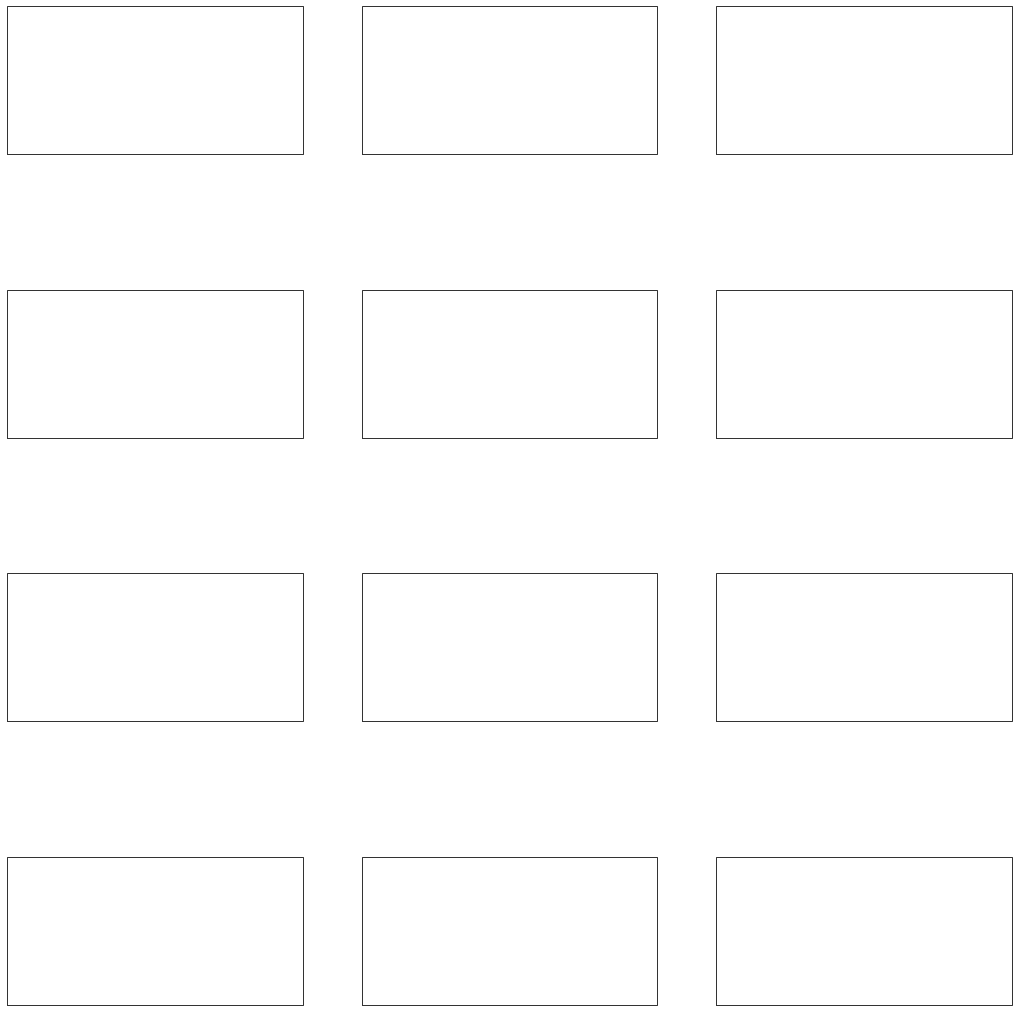

In [130]:
'''
List of Variables:
## 2D ##
SN   : accum. of snow precip.  |  Snow amount in liquid water equivalent of falling snow. [m]
SN1  : accum. ice crystals (M-Y)  |  Accumulated ice crystals (Milbrandt-Yau) [m]
SN2  : accum. snow (M-Y)  |  Accumulated snow (Milbrandt-Yau) [m]
SN3  : accum. graupel (M-Y)  |  Accumulated graupel (Milbrandt-Yau) [m]
RN   : accum. of liquid precip.  |  Liquid precipitation amount [m]
RN1  : accum. liquid drizzle (M-Y)  |  Accumulated liquid drizzle (Milbrandt-Yau) [m]
RN2  : accum. liquid rain (M-Y)  |  Accumulated liquid rain (Milbrandt-Yau) [m]
PR   : accum. of total precip.  |  Quantity of precipitation [m]

PX: 
MPNC:
MPNR:
HU: Humidite specifique
MPQC:
MPQR:
QT1:
GZ: Geopotential Height
TT: Air Temperature
HR: Relative Humidity
WW: Vertical Motion
UU: Wind U
VV: Wind V
QR: Relative Vorticity
ZZ:
QTI1:
QMI1:
NTI1:
BMI1:
PN: Sea level pressure

## 3D ##
TD:
TT: Air Temperature
HU: Humidite specifique
WW: Vertical Motion
UU: Wind U
VV: Wind V
GZ: Geopotential Height
QQ: Absolute Vorticity
P0: Surface Pressure
ES: Dew Point Depression

'''
typ = 'pres'
typ = 'model'

y = 2021
m = 4
d = 19
h = [0,6,12,18]      

f_hrdps = '/upslope/winger/WCPS/HRDPS_SAJESS'
f_hrdps = '/chinook/cruman/Data/HRDPS_SAJESS'

# Same file name for pres and model
#filename = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{h[0]:02d}_{prev[5]:03d}_zoom"

varname = "TT"
unit = r"${\rm ^\circ C}$"     # r + symbol of the unit of the values ("m", "%", "${\rm ^\circ C}$", "m/s", "${\rm W/m^2}$", ...)
val_min  =  -5
val_max  =  20
val_int  =  1
cmap = plt.cm.jet
ip1=76696048  # For TT 1.5m
#ip1=75597472 # For UU, VV 10m
# PN does not have IP1

proj = True
for hour in h:
    aux_data = []
    aux_title = []
    dt = datetime(y, m, d, hour)
    for prev in range(0,48+1):
        aux = dt + timedelta(hours=prev)
        title = f"F{prev:03d} {aux.year}{aux.month:02d}{aux.day:02d} {aux.hour:02d}Z"
        
        print(f"Starting the plot for {title}")
        #read the file.
        filename = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_{prev:03d}_zoom"
        # Openning the files
        # I have one file per hour
        field, tics, lat, lon = readFile(filename, varname, ip1, RPNDate(aux))              
        
        if proj:
            # 2-D Mapping - if needed
            # -----------------------
            # Get positions of rotated equator from IG1-4 of the tictac's
            (Grd_xlat1,Grd_xlon1,Grd_xlat2,Grd_xlon2) = rmn.cigaxg('E', tics['ig1'],tics['ig2'],tics['ig3'],tics['ig4'])
            # Use Sasha's RotatedLatLon to get the rotation matrix
            rll = RotatedLatLon( lon1=Grd_xlon1, lat1=Grd_xlat1, lon2=Grd_xlon2, lat2=Grd_xlat2) # the params come from gemclim_settings.nml
            # Use Sasha's get_cartopy_projection_obj to get the cartopy object for the projection and domain defined by the coordinates
            myProj = rll.get_cartopy_projection_obj()
            proj = False
            
            f, axs = plt.subplots(4, 3, figsize=(18, 20), subplot_kw={'projection': myProj})
            
        
        
        #for i, ax in enumerate(axs.flat):
            # Plot the figure
        #print(prev%12)
        aux_data.append(field)
        aux_title.append(title)
        #ax[prev%12] = plotVar(ax[prev%12], lon, lat, field, cmap, val_max, val_min, val_int, unit, title)
        
        if (prev+1)%12 == 0:
            # Close the figure and start a new instance                        
            
            if prev != 0:
                axs, im = plotVar(axs, lon, lat, aux_data, cmap, val_max, val_min, val_int, unit, aux_title)
                f.subplots_adjust(wspace=0.15, hspace=0.2)
                
                # Colorbar
                cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
                ints = ( (val_max-val_min+val_int) / val_int)
                color_ticks = np.linspace(val_min, val_max, int(ints))
                cb = f.colorbar(mappable=im, cax=cbar_ax, ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
                #cb.set_label('Accumulated Snow (mm) / Wind Speed (km/h)', size=24)
                cbar_ax.tick_params(labelsize=20)
                                
                cbar_ax.set_title(unit, fontsize=20)
                
                
                # Save fig
                #plt.show()
                plt.savefig(f'fig_HRDPS_{varname}_Hour{hour}_prev{prev+1:02d}.png')
                plt.close()
                aux_data = []
                aux_title = []
                
           # if prev != 48:
                # Create a new instance of the plot
                f, axs = plt.subplots(4, 3, figsize=(18, 20), subplot_kw={'projection': myProj})                                

                  

In [129]:
def readFile(filename, var, ip1, datev):
    # Read one record
    # ---------------
    fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file      
    rec = rmn.fstlir(fid,nomvar=var,ip1=ip1,datev=datev.datev)        # Read the full record of variable 'varname'        
    field = rec['d']#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname'

    mygrid = rmn.readGrid(fid,rec)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
    latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
    lat = latlondict['lat']#[i1:i2,j1:j2]                     # Assign 'lat' to 2-D latitude field
    lon = latlondict['lon']#[i1:i2,j1:j2]                    # Assign 'lon' to 2-D longitude field
    # Get grid rotation for projection of 2-D field for mapping -  if needed
    tics = rmn.fstlir(fid,nomvar='^^', ip1=rec['ig1'],ip2=rec['ig2'],ip3=rec['ig3']) # Read corresponding tictac's
    # Close the RPN file
    rmn.fstcloseall(fid) 
    
    return field, tics, lat, lon

In [128]:
def plotVar(axs, lon, lat, var, cmap, val_max, val_min, val_int, unit, title):
    xll, yll = lon[0, 0],lat[0, 0]
    xur, yur = lon[-1, -1],lat[-1, -1]
    
    for i, ax in enumerate(axs.flat):
    
        # Set geographic features    
        ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
        ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
        #ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
        #ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche riviÃ ̈res
        coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # C
        ax.add_feature(coast, edgecolor='black')
        states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
        ax.add_feature(states_provinces, edgecolor='black')
        ax.set_extent([xll+2.1, xur-2.55, yll-0.65, yur+1.6])

        # Set color map
        #cmap = plt.cm.jet
        # Set min, max and interval for color plot
        ints = ( (val_max-val_min+val_int) / val_int)
        color_bnds  = np.linspace(val_min, val_max, int(ints))
        color_ticks = np.linspace(val_min, val_max, int(ints))
        norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
        # Plot figure
        cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        #cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        # Plot colorbar
        #cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
        #cb.ax.set_title(unit)
        # Plot title
        ax.set_title(title[i], fontsize=20)
    
    return axs, cs
    

In [167]:
def plotVarPR(axs, lon, lat, var, cmap, val_max, val_min, val_int, unit, title):
    xll, yll = lon[0, 0],lat[0, 0]
    xur, yur = lon[-1, -1],lat[-1, -1]
    
    for i, ax in enumerate(axs.flat):
    
        # Set geographic features    
        ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
        ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
        #ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
        #ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche riviÃ ̈res
        coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # C
        ax.add_feature(coast, edgecolor='black')
        states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
        ax.add_feature(states_provinces, edgecolor='black')
        ax.set_extent([xll+2.1, xur-2.55, yll-0.65, yur+1.6])

        # Set color map
        #cmap = plt.cm.jet
        # Set min, max and interval for color plot
        #ints = ( (val_max-val_min+val_int) / val_int)
        #color_bnds  = np.linspace(val_min, val_max, int(ints))
        color_bnds = [0,1,5,10,20,30,40,50]
        #color_ticks = np.linspace(val_min, val_max, int(ints))
        color_ticks = [0,1,5,10,20,30,40,50]
        norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
        # Plot figure
        cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        #cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        # Plot colorbar
        #cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
        #cb.ax.set_title(unit)
        # Plot title
        ax.set_title(title[i], fontsize=20)
    
    return axs, cs
    

In [115]:
def plotVarWindPN(axs, lon, lat, varU, varV, varPN, cmap, val_max, val_min, val_int, unit, title):
    xll, yll = lon[0, 0],lat[0, 0]
    xur, yur = lon[-1, -1],lat[-1, -1]
    
    for i, ax in enumerate(axs.flat):
    
        # Set geographic features    
        ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
        ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
        #ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
        ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
        #ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche riviÃ ̈res
        coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # C
        ax.add_feature(coast, edgecolor='black')
        states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
        ax.add_feature(states_provinces, edgecolor='black')
        ax.set_extent([xll+2.1, xur-2.55, yll-0.65, yur+1.6])

        # Set color map
        #cmap = plt.cm.jet
        # Set min, max and interval for color plot
        ints = ( (val_max-val_min+val_int) / val_int)
        color_bnds  = np.linspace(val_min, val_max, int(ints))
        color_ticks = np.linspace(val_min, val_max, int(ints))
        norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
        # Plot figure
        # Plot figure
        cs = ax.contour(lon, lat, varPN[i],color_bnds,colors='black',linewidths=0.5,transform=ccrs.PlateCarree())
        #ax.clabel(cs, fontsize=18, inline=True,fmt='%0.0f')
        cs = ax.pcolormesh(lon, lat, varPN[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        Q = ax.quiver(lon[::15,::15], lat[::15,::15], varU[i][::15,::15], varV[i][::15,::15],transform=ccrs.PlateCarree(),color='black')
        qk = ax.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
                           coordinates='figure',transform=ccrs.PlateCarree())
        #cs = ax.pcolormesh(lon, lat, var[i],norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        #cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
        # Plot colorbar
        #cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
        #cb.ax.set_title(unit)
        # Plot title
        ax.set_title(title[i], fontsize=20)
    
    return axs, cs
    

Starting the plot for F000 20210419 00Z
{}
260.0 53.0 275.0 50.0
Starting the plot for F001 20210419 01Z
Starting the plot for F002 20210419 02Z
Starting the plot for F003 20210419 03Z
Starting the plot for F004 20210419 04Z
Starting the plot for F005 20210419 05Z
Starting the plot for F006 20210419 06Z
Starting the plot for F007 20210419 07Z
Starting the plot for F008 20210419 08Z
Starting the plot for F009 20210419 09Z
Starting the plot for F010 20210419 10Z
Starting the plot for F011 20210419 11Z
Starting the plot for F012 20210419 12Z
Starting the plot for F013 20210419 13Z
Starting the plot for F014 20210419 14Z
Starting the plot for F015 20210419 15Z
Starting the plot for F016 20210419 16Z
Starting the plot for F017 20210419 17Z
Starting the plot for F018 20210419 18Z
Starting the plot for F019 20210419 19Z
Starting the plot for F020 20210419 20Z
Starting the plot for F021 20210419 21Z
Starting the plot for F022 20210419 22Z
Starting the plot for F023 20210419 23Z
Starting the pl

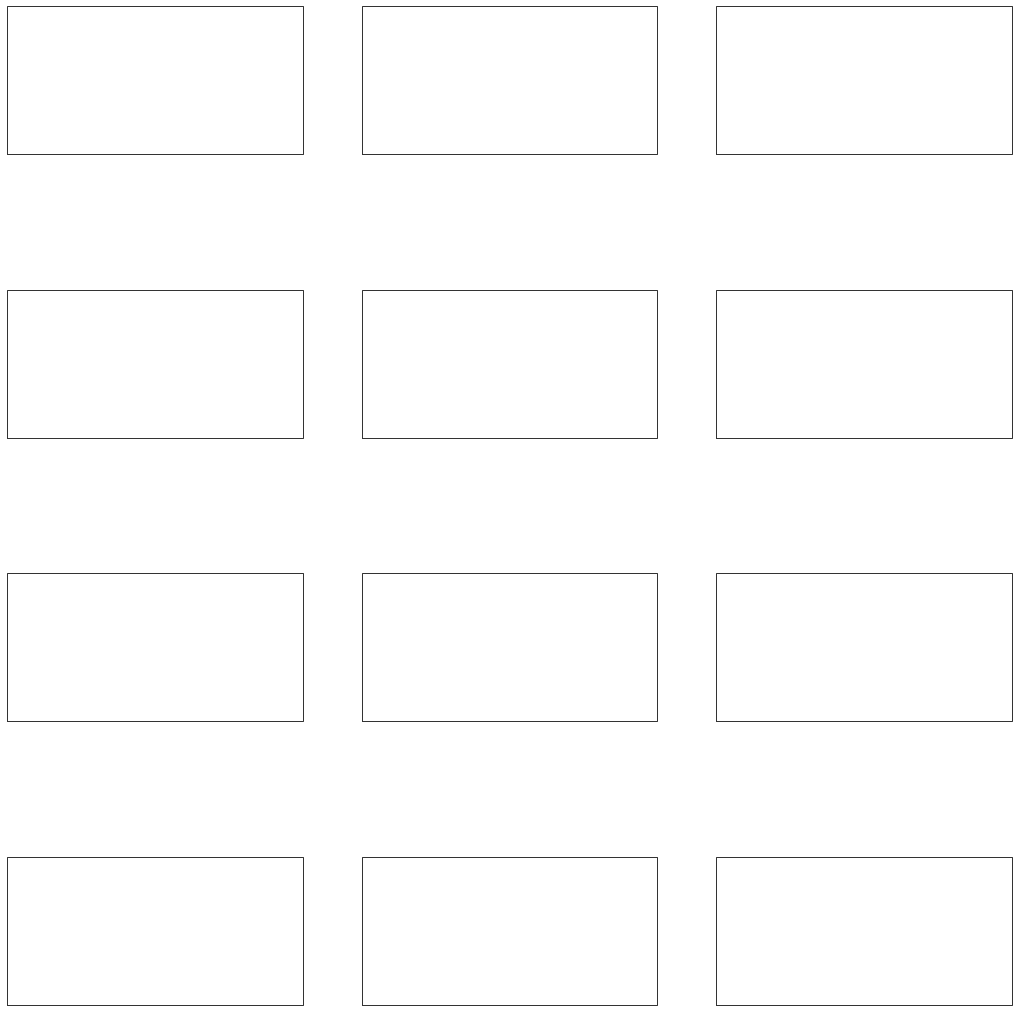

In [119]:
# Plot wind and sea level pressure
typ = 'pres'
typ = 'model'

y = 2021
m = 4
d = 19
h = [0,6,12,18]      

f_hrdps = '/upslope/winger/WCPS/HRDPS_SAJESS'
f_hrdps = '/chinook/cruman/Data/HRDPS_SAJESS'

# Same file name for pres and model
#filename = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{h[0]:02d}_{prev[5]:03d}_zoom"

varname = "TT"
unit = "hPa"     # r + symbol of the unit of the values ("m", "%", "${\rm ^\circ C}$", "m/s", "${\rm W/m^2}$", ...)
val_min  =  992
val_max  =  1020
val_int  =  1
cmap = plt.cm.jet
ip1=76696048  # For TT 1.5m
ip1=75597472 # For UU, VV 10m
# PN does not have IP1
#aux_data = []
#aux_U = []
#aux_V = []
aux_title = []
proj = True
for hour in h:
    aux_data = []
    aux_U = []
    aux_V = []
    aux_title = []
    dt = datetime(y, m, d, hour)
    for prev in range(0,48+1):
        aux = dt + timedelta(hours=prev)
        title = f"F{prev:03d} {aux.year}{aux.month:02d}{aux.day:02d} {aux.hour:02d}Z"
        
        print(f"Starting the plot for {title}")
        #read the file.
        filename = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_{prev:03d}_zoom"
        # Openning the files
        # I have one file per hour
        field_UU, tics, lat, lon = readFile(filename, "UU", ip1, RPNDate(aux))
        field_VV, tics, lat, lon = readFile(filename, "VV", ip1, RPNDate(aux))
        field_PN, tics, lat, lon = readFile(filename, "PN", 0, RPNDate(aux))
        
        if proj:
            # 2-D Mapping - if needed
            # -----------------------
            # Get positions of rotated equator from IG1-4 of the tictac's
            (Grd_xlat1,Grd_xlon1,Grd_xlat2,Grd_xlon2) = rmn.cigaxg('E', tics['ig1'],tics['ig2'],tics['ig3'],tics['ig4'])
            # Use Sasha's RotatedLatLon to get the rotation matrix
            rll = RotatedLatLon( lon1=Grd_xlon1, lat1=Grd_xlat1, lon2=Grd_xlon2, lat2=Grd_xlat2) # the params come from gemclim_settings.nml
            # Use Sasha's get_cartopy_projection_obj to get the cartopy object for the projection and domain defined by the coordinates
            myProj = rll.get_cartopy_projection_obj()
            proj = False
            
            f, axs = plt.subplots(4, 3, figsize=(18, 20), subplot_kw={'projection': myProj})
            
        
        
        #for i, ax in enumerate(axs.flat):
            # Plot the figure
        #print(prev%12)
        aux_data.append(field_PN)
        aux_U.append(field_UU)
        aux_V.append(field_VV)
        aux_title.append(title)
        #ax[prev%12] = plotVar(ax[prev%12], lon, lat, field, cmap, val_max, val_min, val_int, unit, title)
        
        if (prev+1)%12 == 0:
            # Close the figure and start a new instance                        
            
            if prev != 0:
                axs, im = plotVarWindPN(axs, lon, lat, aux_U, aux_V, aux_data, cmap, val_max, val_min, val_int, unit, aux_title)                
                f.subplots_adjust(wspace=0.15, hspace=0.2)
                
                # Colorbar
                cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
                ints = ( (val_max-val_min+val_int) / val_int)
                color_ticks = np.linspace(val_min, val_max, int(ints))
                cb = f.colorbar(mappable=im, cax=cbar_ax, ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
                #cb.set_label('Accumulated Snow (mm) / Wind Speed (km/h)', size=24)
                cbar_ax.tick_params(labelsize=20)
                                
                cbar_ax.set_title(unit, fontsize=20)
                
                
                # Save fig
                #plt.show()
                plt.savefig(f'fig_HRDPS_PN_Wind_Hour{hour}_prev{prev+1:02d}.png')
                plt.close()
                aux_data = []
                aux_title = []
                aux_U = []
                aux_V = []
                
            #if prev != 48:
                # Create a new instance of the plot
                f, axs = plt.subplots(4, 3, figsize=(18, 20), subplot_kw={'projection': myProj})                                

                  

Starting the plot for F000 20210419 00Z
{}
260.0 53.0 275.0 50.0
Starting the plot for F001 20210419 01Z
Starting the plot for F002 20210419 02Z
Starting the plot for F003 20210419 03Z
Starting the plot for F004 20210419 04Z
Starting the plot for F005 20210419 05Z
Starting the plot for F006 20210419 06Z
Starting the plot for F007 20210419 07Z
Starting the plot for F008 20210419 08Z
Starting the plot for F009 20210419 09Z
Starting the plot for F010 20210419 10Z
Starting the plot for F011 20210419 11Z
Starting the plot for F012 20210419 12Z
Starting the plot for F013 20210419 13Z
Starting the plot for F014 20210419 14Z
Starting the plot for F015 20210419 15Z
Starting the plot for F016 20210419 16Z
Starting the plot for F017 20210419 17Z
Starting the plot for F018 20210419 18Z
Starting the plot for F019 20210419 19Z
Starting the plot for F020 20210419 20Z
Starting the plot for F021 20210419 21Z
Starting the plot for F022 20210419 22Z
Starting the plot for F023 20210419 23Z
Starting the pl

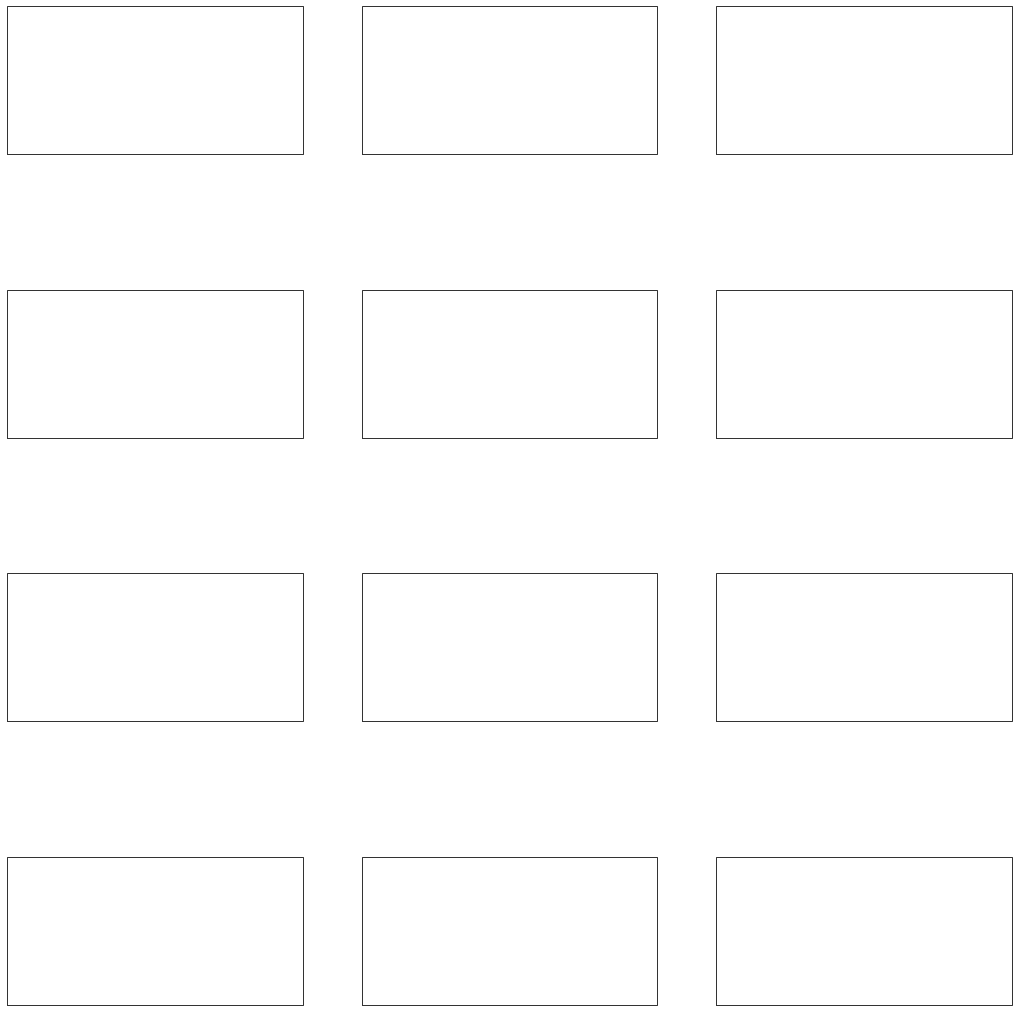

In [169]:
'''
SN   : accum. of snow precip.  |  Snow amount in liquid water equivalent of falling snow. [m]
SN1  : accum. ice crystals (M-Y)  |  Accumulated ice crystals (Milbrandt-Yau) [m]
SN2  : accum. snow (M-Y)  |  Accumulated snow (Milbrandt-Yau) [m]
SN3  : accum. graupel (M-Y)  |  Accumulated graupel (Milbrandt-Yau) [m]
RN   : accum. of liquid precip.  |  Liquid precipitation amount [m]
RN1  : accum. liquid drizzle (M-Y)  |  Accumulated liquid drizzle (Milbrandt-Yau) [m]
RN2  : accum. liquid rain (M-Y)  |  Accumulated liquid rain (Milbrandt-Yau) [m]
PR   : accum. of total precip.  |  Quantity of precipitation [m]
'''
# Plot wind and sea level pressure
typ = 'pres'
typ = 'model'

y = 2021
m = 4
d = 19
h = [0,6,12,18]      

f_hrdps = '/upslope/winger/WCPS/HRDPS_SAJESS'
f_hrdps = '/chinook/cruman/Data/HRDPS_SAJESS'

# Same file name for pres and model
#filename = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{h[0]:02d}_{prev[5]:03d}_zoom"

varname = "PR"
unit = "mm"     # r + symbol of the unit of the values ("m", "%", "${\rm ^\circ C}$", "m/s", "${\rm W/m^2}$", ...)
val_min  =  992
val_max  =  1020
val_int  =  1
cmap = plt.cm.jet
ip1=76696048  # For TT 1.5m
ip1=75597472 # For UU, VV 10m
ip1=0 # for PR, RN
# PN does not have IP1
#aux_data = []
#aux_U = []
#aux_V = []
aux_title = []
proj = True
for hour in h:
    aux_data = []    
    aux_title = []
    dt = datetime(y, m, d, hour)
    for prev in range(0,48+1):
        aux = dt + timedelta(hours=prev)
        title = f"F{prev:03d} {aux.year}{aux.month:02d}{aux.day:02d} {aux.hour:02d}Z"
        
        print(f"Starting the plot for {title}")
        #read the file.
        filename = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_{prev:03d}_zoom"
        # Openning the files
        # I have one file per hour
        field, tics, lat, lon = readFile(filename, varname, ip1, RPNDate(aux))        
        field = field*1000
        if proj:
            # 2-D Mapping - if needed
            # -----------------------
            # Get positions of rotated equator from IG1-4 of the tictac's
            (Grd_xlat1,Grd_xlon1,Grd_xlat2,Grd_xlon2) = rmn.cigaxg('E', tics['ig1'],tics['ig2'],tics['ig3'],tics['ig4'])
            # Use Sasha's RotatedLatLon to get the rotation matrix
            rll = RotatedLatLon( lon1=Grd_xlon1, lat1=Grd_xlat1, lon2=Grd_xlon2, lat2=Grd_xlat2) # the params come from gemclim_settings.nml
            # Use Sasha's get_cartopy_projection_obj to get the cartopy object for the projection and domain defined by the coordinates
            myProj = rll.get_cartopy_projection_obj()
            proj = False
            
            f, axs = plt.subplots(4, 3, figsize=(18, 20), subplot_kw={'projection': myProj})
            
        
        
        #for i, ax in enumerate(axs.flat):
            # Plot the figure
        #print(prev%12)
        aux_data.append(field)        
        aux_title.append(title)
        #ax[prev%12] = plotVar(ax[prev%12], lon, lat, field, cmap, val_max, val_min, val_int, unit, title)
        
        if (prev+1)%12 == 0:
            # Close the figure and start a new instance                        
            
            if prev != 0:
                axs, im = plotVarPR(axs, lon, lat, aux_data, cmap, val_max, val_min, val_int, unit, aux_title)                
                f.subplots_adjust(wspace=0.15, hspace=0.2)
                
                # Colorbar
                cbar_ax = f.add_axes([0.92, 0.20, 0.025, 0.6])
                #ints = ( (val_max-val_min+val_int) / val_int)
                #color_ticks = np.linspace(val_min, val_max, int(ints))
                color_ticks = [0,1,5,10,20,30,40,50]
                cb = f.colorbar(mappable=im, cax=cbar_ax, ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
                #cb.set_label('Accumulated Snow (mm) / Wind Speed (km/h)', size=24)
                cbar_ax.tick_params(labelsize=20)
                                
                cbar_ax.set_title(unit, fontsize=20)
                
                
                # Save fig
                #plt.show()
                plt.savefig(f'fig_HRDPS_{varname}_Wind_Hour{hour}_prev{prev+1:02d}.png')
                plt.close()
                aux_data = []
                aux_title = []                
                
            #if prev != 48:
                # Create a new instance of the plot
                f, axs = plt.subplots(4, 3, figsize=(18, 20), subplot_kw={'projection': myProj})                                

                  

In [165]:
#tics = rec
#val_min  =  int(np.min(field))#980
#val_max  =  int(np.max(field))#1030
#val_int  =  int((val_max - val_min)/10)#5
#unit = r"${\rm ^\circ C}$"     # r + symbol of the unit of the values ("m", "%", "${\rm ^\circ C}$", "m/s", "${\rm W/m^2}$", ...)
unit = "hPa"     # r + symbol of the unit of the values ("m", "%", "${\rm ^\circ C}$", "m/s", "${\rm W/m^2}$", ...)
title = "Wind and Sea Level Pressure"
# 2-D Mapping - if needed
# -----------------------
# Get positions of rotated equator from IG1-4 of the tictac's
(Grd_xlat1,Grd_xlon1,Grd_xlat2,Grd_xlon2) = rmn.cigaxg('E', tics['ig1'],tics['ig2'],tics['ig3'],tics['ig4'])
# Use Sasha's RotatedLatLon to get the rotation matrix
rll = RotatedLatLon( lon1=Grd_xlon1, lat1=Grd_xlat1, lon2=Grd_xlon2, lat2=Grd_xlat2) # the params come from gemclim_settings.nml
# Use Sasha's get_cartopy_projection_obj to get the cartopy object for the projection and domain defined by the coordinates
m = rll.get_cartopy_projection_obj()

{}
260.0 53.0 275.0 50.0


In [147]:
val_min  =  0#int(np.min(field_PR))#980
val_max  =  50#int(np.max(field_PR))#1030
val_int  =  5#int((val_max - val_min)/10)#5

In [155]:
field_PR*1000

array([[1.2029204e+00, 1.1603022e+00, 1.1166004e+00, ..., 2.2117430e-02,
        2.5057960e-02, 3.1558923e-02],
       [1.2376369e+00, 1.2014805e+00, 1.1603556e+00, ..., 1.9522112e-02,
        2.7322844e-02, 3.5509605e-02],
       [1.3260107e+00, 1.3212607e+00, 1.2344674e+00, ..., 2.1373734e-02,
        3.0415021e-02, 6.5671802e-02],
       ...,
       [3.0705946e+01, 3.2390560e+01, 3.3054115e+01, ..., 2.9418595e+00,
        2.9558511e+00, 2.9582942e+00],
       [3.4648613e+01, 3.6778336e+01, 3.5528988e+01, ..., 2.8065071e+00,
        2.8282208e+00, 2.8418999e+00],
       [3.2046402e+01, 3.3598427e+01, 3.5131069e+01, ..., 2.7020853e+00,
        2.6754992e+00, 2.7139404e+00]], dtype=float32)

In [163]:
f_hrdps = '/chinook/cruman/Data/HRDPS_SAJESS'
y=2021
m=4
d=19
hour=0
prev=48
typ="model"
filename = f"{f_hrdps}/{typ}/{y}{m:02d}{d:02d}{hour:02d}_{prev:03d}_zoom"
print(filename)
# Read one record
# ---------------
fid = rmn.fstopenall(filename,rmn.FST_RO)   # Open the file
rec_RN = rmn.fstlir(fid,nomvar="RN",ip1=0)        # Read the full record of variable 'varname'
rec_PR = rmn.fstlir(fid,nomvar="PR",ip1=0)
rec_SN = rmn.fstlir(fid,nomvar="SN",ip1=0)
field_RN = rec_RN['d']*1000#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname'
field_PR = rec_PR['d']*1000#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname'
field_SN = rec_SN['d']*1000#[i1:i2,j1:j2]                            # Assign 'field' to the data of 'varname'

mygrid = rmn.readGrid(fid,rec_UU)              # Get the grid information for the (LAM) Grid -- Reads the tictac's
latlondict = rmn.gdll(mygrid)               # Create 2-D lat and lon fields from the grid information
lat = latlondict['lat']#[i1:i2,j1:j2]                     # Assign 'lat' to 2-D latitude field
lon = latlondict['lon']#[i1:i2,j1:j2]                    # Assign 'lon' to 2-D longitude field
# Get grid rotation for projection of 2-D field for mapping -  if needed
tics = rmn.fstlir(fid,nomvar='^^', ip1=rec_UU['ig1'],ip2=rec_UU['ig2'],ip3=rec_UU['ig3']) # Read corresponding tictac's
# Close the RPN file
rmn.fstcloseall(fid) 

/chinook/cruman/Data/HRDPS_SAJESS/model/2021041900_048_zoom


In [15]:
rmn.DecodeIp(76696048, 176265768, 0)

(FLOAT_IP(1.5, 1.5, 4), FLOAT_IP(10.5, 10.5, 10), FLOAT_IP(0.0, 0.0, 10))

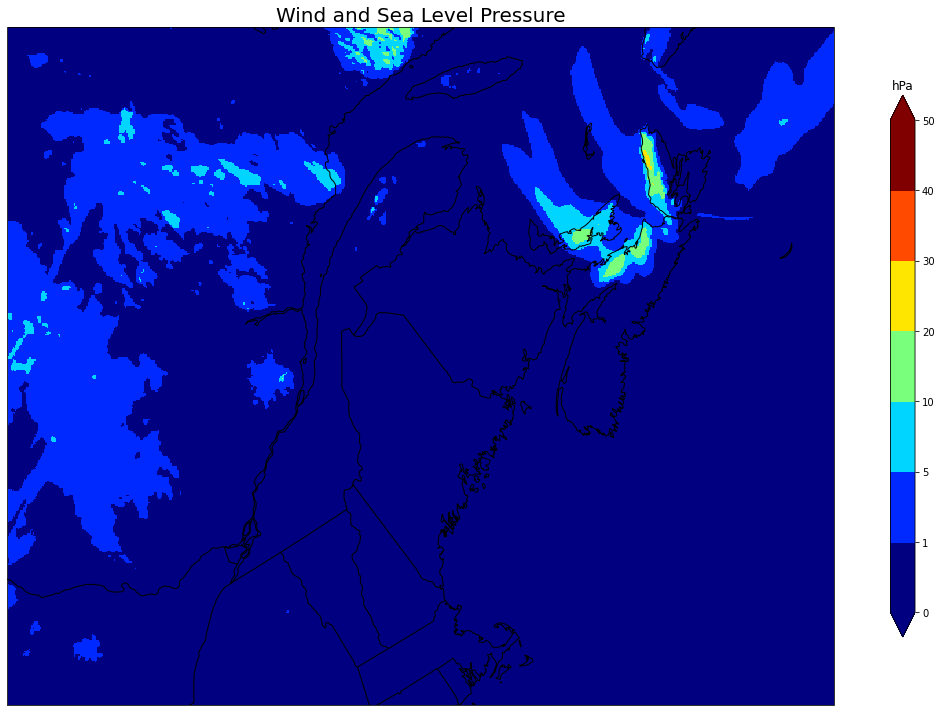

In [166]:
figsize = (16, 10)      # Figure size
fig = plt.figure(figsize=figsize) # Set projection defined by the cartopy object
ax = plt.axes(projection=m)
#ax = plt.axes(projection=myLambert)
# Set corners of the maps
xll, yll = m.transform_point(lon[0, 0],lat[0, 0],ccrs.PlateCarree())
xur, yur = m.transform_point(lon[-1, -1],lat[-1, -1], ccrs.PlateCarree())
xll, yll = lon[0, 0],lat[0, 0]
xur, yur = lon[-1, -1],lat[-1, -1]
# Set geographic features
ax.add_feature(cfeature.OCEAN.with_scale('50m'))      # couche ocean
ax.add_feature(cfeature.LAND.with_scale('50m'))       # couche land
#ax.add_feature(cfeature.LAKES.with_scale('50m'))      # couche lac
ax.add_feature(cfeature.BORDERS.with_scale('50m'))    # couche frontieres
#ax.add_feature(cfeature.RIVERS.with_scale('50m'))     # couche riviÃ ̈res
coast = cfeature.NaturalEarthFeature(category='physical', scale='10m',facecolor='none', name='coastline') # C
ax.add_feature(coast, edgecolor='black')

states_provinces = cfeature.NaturalEarthFeature(category='cultural',name='admin_1_states_provinces_lines',scale='10m',facecolor='none') # Couche provinces
ax.add_feature(states_provinces, edgecolor='black')
ax.set_extent([xll+2.1, xur-2.55, yll-0.65, yur+1.6])
#ax.set_extent([xll, xur, yll, yur])
# Set colors
# ----------
# Set color map
cmap = plt.cm.jet
# Set min, max and interval for color plot
ints = ( (val_max-val_min+val_int) / val_int)
color_bnds  = np.linspace(val_min, val_max, int(ints))
color_bnds = [0,1,5,10,20,30,40,50]
color_ticks = np.linspace(val_min, val_max, int(ints))
color_ticks = [0,1,5,10,20,30,40,50]
norm = colors.BoundaryNorm(boundaries=color_bnds, ncolors=256)
# Plot figure
#cs = plt.contour(lon, lat, field_PN,color_bnds,colors='black',transform=ccrs.PlateCarree())
#ax.clabel(cs, fontsize=18, inline=True,fmt='%0.0f')
cs = plt.pcolormesh(lon, lat, field_SN,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
#Q = plt.quiver(lon[::15,::15], lat[::15,::15], field_UU[::15,::15], field_VV[::15,::15],transform=ccrs.PlateCarree(),color='black')
#qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$1 \frac{m}{s}$', labelpos='E',
#                   coordinates='figure',transform=ccrs.PlateCarree())
#cs = plt.contourf(lon, lat, field,norm=norm,cmap=cmap,transform=ccrs.PlateCarree())
# Plot colorbar
cb = plt.colorbar(mappable=cs,ticks=color_ticks,orientation="vertical",pad=0.05,shrink=0.8, extend="both")
cb.ax.set_title(unit)
# Plot title
plt.title(title, fontsize=20)
# To help the layout of the figure after saving
fig.canvas.draw()
plt.tight_layout()  # To help with the layout of the figure after saving
# Save figure
plt.show()
#plt.savefig('NB_small_domain.png')

array([ 994.,  996.,  998., 1000., 1002., 1004., 1006., 1008., 1010.,
       1012.])